<a href="https://colab.research.google.com/github/Goldfiinch/Project-4/blob/main/Project_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [220]:
!apt-get update # Update apt-get repository.
!apt-get install openjdk-8-jdk-headless -qq > /dev/null # Install Java.
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz # Download Apache Sparks.
!tar xf spark-3.1.1-bin-hadoop3.2.tgz # Unzip the tgz file.
!pip install -q findspark # Install findspark. Adds PySpark to the System path during runtime.

# Set environment variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

# Initialize findspark
import findspark
findspark.init()

# Create a PySpark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 229 kB in 2s (98.2 kB/s)
Reading package lists... Done


In [221]:
# Import CSV files into spark DataFrame.
spy_spark_df = spark.read.csv("SPY.csv")
vix_spark_df = spark.read.csv("VIX.csv")

# Convert to Pandas DataFrame for cleaning.
import pandas as pd
spy_df = spy_spark_df.toPandas()
vix_df = vix_spark_df.toPandas()

,_c0,_c1,_c2,_c3,_c4,_c5,_c6
0,Date,Open,High,Low,Close,Adj Close,Volume
1,1993-01-25,11.420000,13.160000,10.980000,12.420000,12.420000,0
2,1993-02-01,12.510000,13.450000,11.690000,12.900000,12.900000,0
3,1993-02-08,13.150000,14.260000,12.200000,12.380000,12.380000,0
4,1993-02-15,13.440000,16.650000,13.350000,15.020000,15.020000,0
...,...,...,...,...,...,...,...
1616,2024-01-08,14.000000,14.180000,12.350000,12.700000,12.700000,0
1617,2024-01-15,14.120000,15.400000,13.280000,13.300000,13.300000,0
1618,2024-01-22,13.770000,14.100000,12.410000,13.260000,13.260000,0
1619,2024-01-29,13.980000,15.350000,13.180000,13.850000,13.850000,0


In [222]:
# Drop unnecessary columns.
vix_df = vix_df.drop(columns=['_c1', '_c2', '_c3', '_c5', '_c6'])

# Rename columns and drop index numbers.
spy_df = spy_df.rename(columns={"_c0": "Date", "_c1": "Open", "_c2": "High", "_c3": "Low", "_c4": "Close", "_c5": "Adj Close", "_c6": "Volume"})
spy_df = spy_df.drop([0])

vix_df = vix_df.rename(columns={"_c0": "Date", "_c4": "VIX"})
vix_df = vix_df.drop([0])

In [223]:
# Merge the SPY and VIX DataFrames.
combined_df = pd.merge(spy_df, vix_df, how='outer', on='Date')

# Set Date column as the dataframe index.
combined_df['Date'] = pd.to_datetime(combined_df['Date'])
combined_df.set_index('Date', inplace=True)

# Convert data in columns from objects to numeric.
for col in combined_df.columns:
    combined_df[col] = pd.to_numeric(combined_df[col], errors='ignore')

# Dropping last column because it contains a NA value.
combined_df = combined_df[:-1]

# Reducing the number size of the volume data to help the model run faster.
combined_df["Volume"] = combined_df["Volume"].div(1000000)
combined_df["Volume"] = combined_df["Volume"].round(1)

combined_df.head()

,Open,High,Low,Close,Adj Close,Volume,VIX
Date,,,,,,,
1993-01-25,43.96875,43.96875,43.75000,43.93750,24.840683,1.0,12.42
1993-02-01,43.96875,45.09375,43.96875,44.96875,25.423706,2.2,12.90
1993-02-08,44.96875,45.12500,44.53125,44.59375,25.211708,1.2,12.38
1993-02-15,44.46875,44.46875,42.81250,43.56250,24.628672,1.0,15.02
1993-02-22,43.68750,44.43750,43.46875,44.40625,25.105690,1.0,13.16


In [224]:
# Create "SPY Tomorrow" column and "Target" column.
combined_df["SPY Tomorrow"] = combined_df["Adj Close"].shift(-1)
combined_df["Target"] = (combined_df["SPY Tomorrow"] > combined_df["Adj Close"]).astype(int)

combined_df.head()

,Open,High,Low,Close,Adj Close,Volume,VIX,SPY Tomorrow,Target
Date,,,,,,,,,
1993-01-25,43.96875,43.96875,43.75000,43.93750,24.840683,1.0,12.42,25.423706,1
1993-02-01,43.96875,45.09375,43.96875,44.96875,25.423706,2.2,12.90,25.211708,0
1993-02-08,44.96875,45.12500,44.53125,44.59375,25.211708,1.2,12.38,24.628672,0
1993-02-15,44.46875,44.46875,42.81250,43.56250,24.628672,1.0,15.02,25.105690,1
1993-02-22,43.68750,44.43750,43.46875,44.40625,25.105690,1.0,13.16,25.300035,1


In [225]:
# Reduced the data's time range.
combined_df = combined_df.loc["2000-01-01":].copy()

In [226]:
# Create Model.
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

# Test Train Split
train = combined_df.iloc[:-250]  # Training data
test = combined_df.iloc[-250:]   # Test data

# Creating a list of predictors.
predictors = ["Open", "High", "Low", "Close", "Adj Close", "Volume", "VIX"]

# Fit the model.
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [228]:
# Calculate precision accuracy score.
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)

precision_score(test["Target"], preds)

0.5720524017467249

In [230]:
#Lag Features & SMA
lag_features = ['Adj Close']
lags = range(1, 4)  # for example, create lags for 1, 2, and 3 days
for lag in lags:
  combined_df[f'Adj Close Lag {lag}'] = combined_df['Adj Close'].shift(lag)

# Add a simple moving average (SMA) for 'Adj Close'
window = 5  # 5-day SMA
combined_df['SMA 5'] = combined_df['Adj Close'].rolling(window=window).mean()

# Handle missing values introduced by lag and SMA features
combined_df.dropna(inplace=True)

,Open,High,Low,Close,Adj Close,Volume,VIX,SPY Tomorrow,Target,Adj Close Lag 1,Adj Close Lag 2,Adj Close Lag 3,SMA 5
Date,,,,,,,,,,,,,
2000-01-31,135.812500,144.000000,135.000000,142.593750,92.046234,38.3,21.540001,89.524696,0,87.709198,93.236443,94.870384,92.389182
2000-02-07,142.562500,144.562500,138.031250,138.687500,89.524696,35.8,24.420000,87.346107,0,92.046234,87.709198,93.236443,91.477391
2000-02-14,139.781250,141.218750,134.625000,135.312500,87.346107,45.4,26.000000,86.065132,0,89.524696,92.046234,87.709198,89.972536
2000-02-21,135.187500,137.468750,133.093750,133.328125,86.065132,56.5,25.200001,91.098145,1,87.346107,89.524696,92.046234,88.538273
2000-02-28,133.375000,141.718750,132.718750,141.125000,91.098145,48.9,19.209999,90.452660,0,86.065132,87.346107,89.524696,89.216063
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-25,474.070007,477.549988,473.299988,475.309998,475.309998,322.8,12.450000,467.920013,0,473.649994,467.434814,458.341705,466.396533
2024-01-01,472.160004,473.670013,466.429993,467.920013,467.920013,397.5,13.350000,476.679993,1,475.309998,473.649994,467.434814,468.531305
2024-01-08,468.429993,478.600006,468.299988,476.679993,476.679993,344.0,12.700000,482.429993,1,467.920013,475.309998,473.649994,472.198962


In [231]:
#Create a new Model.
model_1 = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

# Test Train Split
train_1 = combined_df.iloc[:-250]  # Training data
test_1 = combined_df.iloc[-250:]   # Test data

# Updating list of predictors.
predictors_1 = ["High", "Low", "Adj Close", "Volume", "VIX", "Adj Close Lag 1", "Adj Close Lag 2", "Adj Close Lag 3", "SMA 5"]

# Fit the optimized model
model_1.fit(train_1[predictors_1], train_1["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [232]:
# Recalculate precision accuracy score.
preds_1 = model_1.predict(test_1[predictors_1])
preds_1 = pd.Series(preds_1, index=test_1.index)

precision_score(test_1["Target"], preds_1)

0.5860215053763441

In [233]:
# Import CSV files into spark DataFrame
tnx_spark_df = spark.read.csv("TNX.csv")

# Convert to Pandas dataframe for cleaning
tnx_df = tnx_spark_df.toPandas()
tnx_df = tnx_df.drop(columns=['_c1', '_c2', '_c3', '_c5', '_c6'])

# Rename columns
tnx_df = tnx_df.rename(columns={"_c0": "Date", "_c4": "10-Y Treasury"})
tnx_df = tnx_df.drop([0])

# Convert "Date" column to datetime and set as index.
tnx_df['Date'] = pd.to_datetime(tnx_df['Date'])
tnx_df.set_index('Date', inplace=True)

# Convert all other columns to numeric.
for col in tnx_df.columns:
     tnx_df[col] = pd.to_numeric(tnx_df[col], errors='ignore')

In [234]:
# Merged the tnx_df with the combined_df
combined_df = pd.merge(combined_df, tnx_df, how = "outer", on = "Date")
combined_df = combined_df[:-1]
combined_df = combined_df.loc["2000-01-01":].copy()
combined_df = combined_df.dropna()

<ipython-input-234-85185afa15e6>:5: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  combined_df = combined_df.loc["2000-01-01":].copy()


In [236]:
#Create a new Model.
model_2 = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

# Test Train Split
train_2 = combined_df.iloc[:-250]  # Training data
test_2 = combined_df.iloc[-250:]   # Test data

# Updating list of predictors.
predictors_2 = ["High", "Low", "Adj Close", "Volume", "VIX", "Adj Close Lag 1", "Adj Close Lag 2", "Adj Close Lag 3", "SMA 5", "10-Y Treasury"]

# Fit the optimized model
model_2.fit(train_2[predictors_2], train_2["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [237]:
# Recalculate precision accuracy score.
preds_2 = model_2.predict(test_2[predictors_2])
preds_2 = pd.Series(preds_2, index=test_2.index)

precision_score(test_2["Target"], preds_2)

0.5949367088607594

<Axes: xlabel='Date'>

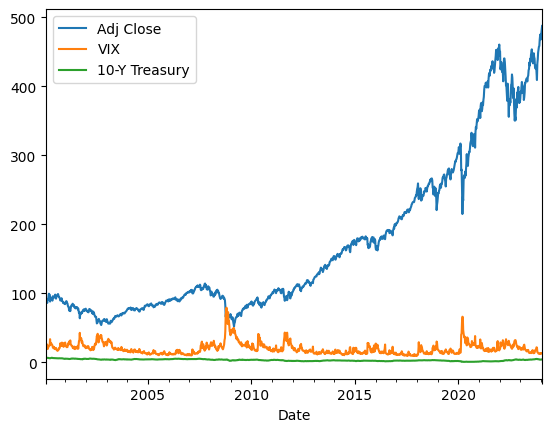

In [238]:
# Create plot to visualize the different indexes.
combined_df.plot.line(y=['Adj Close','VIX', '10-Y Treasury'], use_index=True)